In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
import pickle
import ast

from glob import glob
from PIL import Image
from tqdm import tqdm

In [7]:
# Verifica se a GPU está disponível
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Configuração para utilizar a GPU
    config = tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.keras.backend.set_session(tf.Session(config=config))

In [2]:
# Configuration
SEP = " -<>- "
IMG_SIZE = 299
MAX_LENGTH = 9

# DIRECTORY = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/data/train"

PATH = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/dataset/train"
IMG_PATH = PATH + "/plots/"
BARS_PATH = PATH + "/train_barbbox.idl"
IMGSIZE_PATH = PATH + "/train_imgsize.idl"

START_TOKEN = [1.0, 1.0, 0.0] 
END_TOKEN = [0.0, 0.0, 0.0]

In [3]:
# utilities

def get_normalized_data(bbox, real_imgsize):
    '''
    return bar's center coordinate and height

    Parameters:
    bbox (list): [x1, y1, x2, y2]
    real_imgsize (tuple): (imgsize, bar_direction)
    '''
    
    imgsize, bar_direction = real_imgsize
    # top-left and bottom-right x coordinates divided by image width
    bbox[0] /= imgsize[0]
    bbox[2] /= imgsize[0]
    # top-left and bottom-right y coordinates divided by image height
    bbox[1] /= imgsize[1]
    bbox[3] /= imgsize[1]
    
    # normalized height
    if bar_direction == "vertical":
        height = abs(bbox[3] - bbox[1])
        result = [bbox[3], bbox[1], height]
    else:
        height = abs(bbox[2] - bbox[0])
        result = [bbox[2], bbox[0], height]

    return result

def load_image(image_path):
    img = tf.io.read_file(image_path)
    # decode_jpeg also works for png
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [4]:
all_bars = []
all_img_name_vector = []

# BAR_PATH = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/data/train/train_barbbox.idl"
# IMGSIZE_PATH = "C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/data/train/train_imgsize.idl"


with open(BARS_PATH, "r") as fbar, open(IMGSIZE_PATH, "r") as fsize:
    # fsize is the file that contains the image size
    # fbar is the file that contains the bar's bounding box

    for bars, imgsize in tqdm(zip(fbar, fsize)):
        bars = bars.strip() #remove \n
        imgsize = imgsize.strip() #remove \n
        bars = bars.split(SEP) # split by separator
        imgsize = imgsize.split(SEP) # split by separator
        assert bars[0] == imgsize[0], "image name not match!" # check if the image name is the same
        
        all_img_name_vector.append(IMG_PATH + bars[0]) # add image path to the vector
        boxs = ast.literal_eval(bars[1]) # convert string to list
        imgsize = ast.literal_eval(imgsize[1]) # convert string to tuple
        one_img_bar = [START_TOKEN] # start-token 
        
        for box in boxs:
            bbox = box["bbox"]
            bar_info = get_normalized_data(bbox, imgsize)
            one_img_bar.append(bar_info)
        one_img_bar.append(END_TOKEN) # end-token
        
        # padding the sequence
        if len(one_img_bar) < MAX_LENGTH + 2:
            need = MAX_LENGTH + 2 - len(one_img_bar)
            for i in range(need):
                one_img_bar.append(END_TOKEN)
        
        all_bars.append(one_img_bar)

bars_vector, img_name_vector = shuffle(all_bars, all_img_name_vector, random_state=1)

0it [00:00, ?it/s]

30000it [00:04, 7460.52it/s]


First value: Y coordinate of the center of the bar.

Second value: X-coordinate of the center of the bar.

Third value: Normalized bar height.

In [5]:
# *** unit test section ***
print(len(bars_vector[0]), len(img_name_vector[0]))
print(bars_vector[0])
print(img_name_vector[0])

11 103
[[1.0, 1.0, 0.0], [0.6014492753623188, 0.1497584541062802, 0.45169082125603865], [0.855072463768116, 0.1497584541062802, 0.7053140096618358], [0.8260869565217391, 0.1497584541062802, 0.6763285024154589], [0.5024154589371981, 0.1497584541062802, 0.3526570048309179], [0.8623188405797102, 0.1497584541062802, 0.71256038647343], [0.8502415458937198, 0.1497584541062802, 0.7004830917874396], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/dataset/train/plots/train_10747.png


In [6]:
print(len(img_name_vector), len(bars_vector))

30000 30000


In [7]:
max_length = MAX_LENGTH + 2

# higher 2/3 data just to test the model
# img_name_vector = img_name_vector[:int(len(img_name_vector) * 1/5)]
# bars_vector = bars_vector[:int(len(bars_vector) * 1/5)]

# Create training and validation sets
img_name_train, img_name_val, bar_train, bar_val = train_test_split(img_name_vector, bars_vector, test_size=0.04, random_state=0)

In [8]:
len(img_name_train), len(bar_train), len(img_name_val), len(bar_val)

(28800, 28800, 1200, 1200)

In [9]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64 
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
barinfo_size = 3
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [10]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor, _ = load_image(img_name)
    return img_tensor, cap

In [11]:
# create tf dataset object 
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, bar_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.float32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Attention Model

This class implements the Bahdanau attention mechanism, which is used to calculate attention weights in a neural translation model called Seq2Seq. Bahdanau attention is a form of alignment-based attention that allows the model to focus on different parts of the input while generating the output. In this specific case, the attention is applied to input features generated by a CNN encoder layer.

In [12]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    # units: dimension of the hidden layer
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features: CNN_encoder output
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden: hidden state of the RNN_decoder (last state)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    #print("feature:", features.shape)
    #print("hidden:", hidden_with_time_axis.shape)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context:", context_vector.shape)

    return context_vector, attention_weights

### Encoder

This class represents a CNN encoder. It is used to extract features from an input image. It has a pre-trained convolutional neural network (CNN) layer, which is used to extract features from the image. The extracted features are then passed through a dense (fully connected) layer to properly scale them.

In [13]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

        # load the pre-trained model      
        image_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', pooling=None)
        new_input = image_model.input
        hidden_layer = image_model.output

        # receive the input and output of the pre-trained model
        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        L = len(self.image_features_extract_model.layers)
        
        # last 10 layers are trainable, others are not trainable
        for i, layer in enumerate(self.image_features_extract_model.layers):
          if i < L - 10:
            layer.trainable = False
          else:
            layer.trainable = True

    def call(self, x):
        x = self.image_features_extract_model(x)
        x = tf.reshape(x, [x.shape[0], -1, x.shape[-1]]) # (batch_size, 64, embedding_dim)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder

This class is responsible for decoding in a Seq2Seq model. It uses an RNN decoder layer (in this case, a GRU layer) to generate the output sequence based on the input features and the hidden state from the previous decoder step. It also uses the Bahdanau attention mechanism to weight the input features according to their relative importance at each decoding step.

In [14]:
class RNN_Decoder(tf.keras.Model):
  # RNN_decoder: LSTM
  # embedding_dim: dimension of the embedding layer
  # units: dimension of the hidden layer
  # barinfo_size: dimension of the bar information
  def __init__(self, embedding_dim, units, barinfo_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    # embedding layer to transform the input into a vector of dimension embedding_dim 
    self.embedding = tf.keras.layers.Dense(embedding_dim, activation="relu")
    # GRU: a type of RNN
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units, activation="relu")
    self.fc2 = tf.keras.layers.Dense(barinfo_size, activation="relu")

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, state):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, state)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    # Concatenate the input vector x with the context vector to incorporate relevant information from both the previous bar and the attention-based context. 
    # This allows the decoder to consider both the local information (previous bar) and the global context (graph features) when generating the next bar information.  
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    #print("x:", x.shape)
    #output: a batch of sequences of vectors of dimension units
    #state: the last hidden state of the GRU
    output, state= self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [15]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, barinfo_size)

In [16]:
# Define the optimizer and the loss function

# learning rate decay schedule (exponential decay)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=500, decay_rate=0.96, staircase=True)

# update the weights of the model using the stochastic gradient descent (SGD) optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()

# loss function
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

========================================================================================================

In [17]:
# checkpoint_path = os.path.abspath('.') + "/drive/My Drive/checkpoints/train_xception_more_data"
# if not os.path.exists(checkpoint_path):
#     os.makedirs(checkpoint_path)

# ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [18]:
# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Restoring from previous step ...")
# else:
#     print("Training from scratch ...")

===================================================================================================

In [19]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [20]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the target are not related from image to image
  state = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([START_TOKEN] * BATCH_SIZE, 1)

  # gradient 
  with tf.GradientTape() as tape:
      # getting the output from the encoder
      features = encoder(img_tensor) # (batch_size, 64, embedding_dim) 

      # for each bar in the target sequence
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, state, _ = decoder(dec_input, features, state)
          
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  # averaging the loss
  total_loss = (loss / int(target.shape[1]))

  # getting the trainable variables
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  # calculating the gradients
  gradients = tape.gradient(loss, trainable_variables)

  # updating the weights
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [21]:
EPOCHS = 30

# for epoch in range(start_epoch, EPOCHS):
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # if epoch % 5 == 0:
    #   ckpt_manager.save()

    print ('Epoch {} Loss {:.8f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.11480430
Epoch 1 Batch 100 Loss 0.07537375
Epoch 1 Batch 200 Loss 0.06560831
Epoch 1 Batch 300 Loss 0.05881784
Epoch 1 Batch 400 Loss 0.05701126
Epoch 1 Loss 0.06680817
Time taken for 1 epoch 3876.0840232372284 sec

Epoch 2 Batch 0 Loss 0.05337081
Epoch 2 Batch 100 Loss 0.04978545
Epoch 2 Batch 200 Loss 0.04294818
Epoch 2 Batch 300 Loss 0.03937522
Epoch 2 Batch 400 Loss 0.03861224
Epoch 2 Loss 0.04461679
Time taken for 1 epoch 3733.7640154361725 sec

Epoch 3 Batch 0 Loss 0.03948802
Epoch 3 Batch 100 Loss 0.03504865
Epoch 3 Batch 200 Loss 0.03832355
Epoch 3 Batch 300 Loss 0.03612078
Epoch 3 Batch 400 Loss 0.03867516
Epoch 3 Loss 0.03744440
Time taken for 1 epoch 4834.396625757217 sec

Epoch 4 Batch 0 Loss 0.03301327
Epoch 4 Batch 100 Loss 0.03586934
Epoch 4 Batch 200 Loss 0.03617937
Epoch 4 Batch 300 Loss 0.03584138
Epoch 4 Batch 400 Loss 0.03636916
Epoch 4 Loss 0.03620603
Time taken for 1 epoch 4485.988052606583 sec

Epoch 5 Batch 0 Loss 0.03156341
Epoch 5 Batch 

KeyboardInterrupt: 

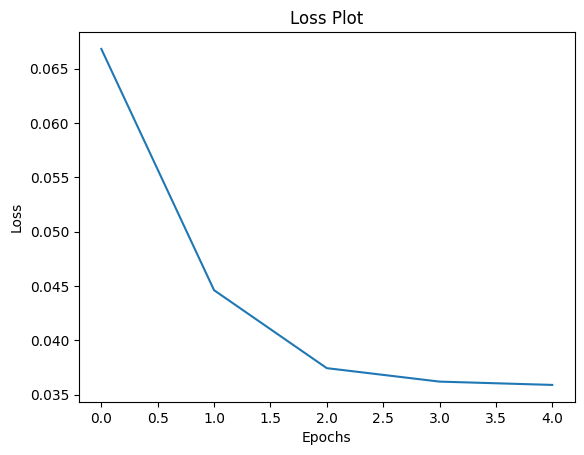

In [22]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [23]:
def evaluate(image):
    # Initialize the attention plot matrix
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Reset the hidden state of the decoder for each evaluation
    hidden = decoder.reset_state(batch_size=1)

    # Preprocess the image and extract relevant features using the encoder
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    features = encoder(temp_input)

    # Set the initial input for the decoder as the start token
    dec_input = tf.expand_dims([START_TOKEN], 0)
    result = []

    # Generate predictions and attention weights for each step up to the maximum length
    # max_length is the maximum length of the target sentence
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Store the attention weights in the attention plot matrix
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Convert the predictions to a numpy array
        predictions = predictions.numpy()

        # Check if the sum of predictions is below a threshold to end the sequence
        if np.sum(predictions[0]) < 0.1:
            break
            
        # Append the predictions to the result list
        result.append(predictions[0])

        # Update the decoder input with the predictions for the next step
        dec_input = tf.expand_dims(predictions, 0)

    # Trim the attention plot matrix to match the length of the result list
    attention_plot = attention_plot[:len(result), :]

    # Return the result list and the attention plot matrix
    return result, attention_plot


In [24]:
import cv2
import os
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(15, 15))

    # save the attention plot image
    # fname = os.path.basename(image)
    # np.save(fname, attention_plot)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (10, 10))
        temp_att = cv2.GaussianBlur(temp_att, (3, 3), 0)
        ax = fig.add_subplot(len_result, 1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
import cv2
import os

def plot_attention(image, result, attention_plot):
    # Load the image as a numpy array
    temp_image = np.array(Image.open(image))
    # Create a figure with the specified size
    fig = plt.figure(figsize=(15, 8))

    # Get the filename of the image
    fname = os.path.basename(image)
    # Save the attention plot matrix as a numpy file
    np.save(fname, attention_plot)

    len_result = len(result)
    for l in range(len_result):
        # Resize the attention plot matrix to match the size of the image
        temp_att = cv2.resize(attention_plot[l], (temp_image.shape[1], temp_image.shape[0]))
        # Apply Gaussian blur to the attention plot matrix
        temp_att = cv2.GaussianBlur(temp_att, (15, 15), 0)
        # Normalize the attention plot matrix
        temp_att = temp_att / np.max(temp_att)
        # Create a color version of the original image
        color_image = cv2.cvtColor(temp_image, cv2.COLOR_GRAY2RGB)
        # Overlay the attention areas on the color image
        overlaid_img = cv2.addWeighted(color_image, 0.6, temp_att, 0.4, 0)

        # Add a subplot to the figure to display the image with attention areas
        ax = fig.add_subplot(len_result, 1, l+1)
        # Remove the axes from the subplot for better visualization
        ax.axis('off')
        # Set the title of the subplot as the corresponding prediction
        ax.set_title(result[l])

        # Display the image with attention areas in the subplot
        ax.imshow(overlaid_img)

    # Adjust the spacing between subplots to avoid overlap
    plt.tight_layout()
    # Show the figure
    plt.show()


C:/Users/fabri/OneDrive/Área de Trabalho/BarchartReverseEngineering/dataset/train/plots/train_3001.jpg


c:\Users\fabri\anaconda\envs\poco\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


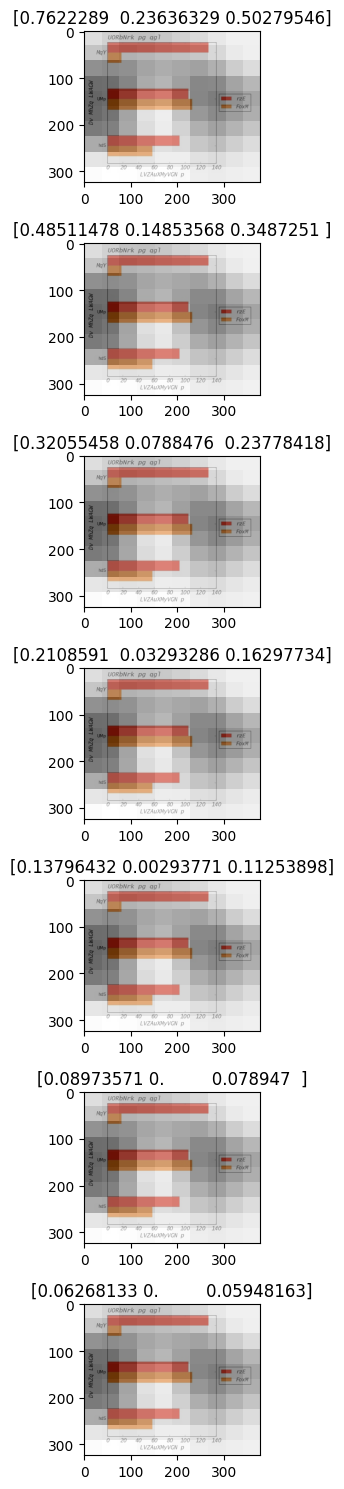

In [28]:
# extractions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

print(image)
result, attention_plot = evaluate(image)

plot_attention(image, result, attention_plot)
# opening the image
#Image.open(img_name_train[rid])